## Здравствуйте, меня зовут *Николай Королев*, вот моё Задание №4 по курсу ПСАД-2020!

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt

from math import sqrt, factorial
from itertools import chain, permutations
from random import shuffle

from tqdm.notebook import tqdm


import seaborn as sns
sns.set()

np.random.seed(228)

%matplotlib inline
# %config InlineBackend.figure_format = 'svg' 

## Задача 1  

Задана обучающая выборка $\widetilde{S}$ размера $n \times 2$, включающая значения переменных $X$ и $Y$.

In [2]:
from scipy.stats import linregress

def draw_linear(x, y, x_name='X', y_name='Y'):
    "Scatter x-y points and draw a LR line."
    slope, intercept, r, _, _ = linregress(x, y)
    x_max, x_min = x.max(), x.min()
    x_range = x_max - x_min
    x_lims = np.array([x_min - 0.1 * x_range, x_max + 0.1 * x_range])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.plot(x, y, 'g+', label='Objects')
    plt.plot(x_lims, intercept + slope * x_lims, 'r--', label=r"LR line with $\rho \approx {:.3f}$".format(r))
    plt.legend()
    plt.show()

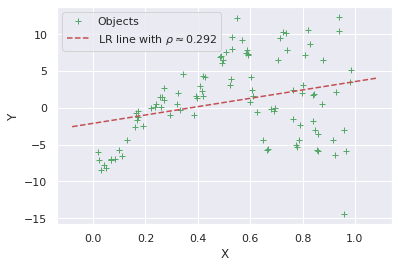

In [3]:
S = np.load("data1.npy")
X, Y = S
draw_linear(X, Y)

* Оцените значимость коэффициента корреляции с помощью трёх тестов: критерия Стюдента, перестановочного теста и бутстреп-критерия. Под значимостью коэффициента в данном случае понимается его значимое отличие от нуля.

* Постройте графики нулевых распределений перестановочного и t-теста, а также распределение статистики бутстреп-теста. Попробуйте использовать функции `sns.lineplot, sns.distplot`. Для параметрического распределения носитель нужно определять самому, а для непараметрического можно рисовать гистограмму по данным как есть.

* Сравните полученные результаты и напишите выводы.

### Критерий Стьюдента

Проведите **двусторонний t-тест** для нулевой гипотезы о равенстве корреляции нулю. Для этого воспользуйтесь центральной предельной теоремой, приведя статистику к стандартизованной форме распределения Стьюдента . Полученное распределение $St(n - 2)$ будет **распределением нулевой гипотезы** $H_0$, а посчитанная статистика $T(X, Y)$ -- **его квантилью**. Достигаемый уровень значимости -- это вероятностная масса нулевого распределения, на которой суммарно получилось такое же или ещё более экстремальное значение статистики. В случае двустороннего теста заранее не известно, по какую сторону от нуля будет значение статистики, поэтому учитываются оба варианта.

In [4]:
def student_significance(X, Y):
    X_mean = X.mean()
    Y_mean = Y.mean()
    numerator = (X * Y).mean() - X_mean * Y_mean
    denominator = ((X * X).mean() - X_mean * X_mean) * ((Y * Y).mean() - Y_mean * Y_mean)
    r = numerator / np.sqrt(denominator)
    t = r * np.sqrt(len(X) - 2) / np.sqrt(1 - r * r)
    p_val = 2 * sp.stats.t(len(X) - 2).sf(abs(t))
    return p_val

### Перестановочный тест

Проведите **двусторонний перестановочный тест** для нулевой гипотезы о равенстве корреляции нулю. Нулевое распределение порождается перебором $n!$ перестановок индексов одной из выборок. Достигаемый уровень значимости -- доля перестановок, на которых получилось такое же или ещё более экстремальное значение статистики. Перебор всех перестановок может быть очень большим, поэтому ограничиваются случайным подмножеством перестановок. В силу симметрии распределения, двусторонний тест учитывает абсолютное значение статистики. 

**Замечание**. Похоже, это очень непросто для создателей библиотек реализовать функцию перестановки, чтобы она возвращала _случайное подмножество_ перестановок. Функция `itertools.permutations` возвращает все возможные _упорядоченные_ перестановки, причём их невозможно перемешать или взять подвыборку, не раскрывая генератор. Функция `np.random.permutation` выполняет одну случайную перестановку, вот её как раз и можно записать в цикле.

In [5]:
def permutation_test_significance(X, Y, n_permutations=100000, verbose=True):
    iterator = tqdm(range(n_permutations), leave=False, disable=not verbose)
    X_mean = X.mean()
    Y_mean = Y.mean()
    numerator = (X * Y).mean() - X_mean * Y_mean
    denominator = np.sqrt(((X * X).mean() - X_mean * X_mean) * ((Y * Y).mean() - Y_mean * Y_mean))
    r = numerator / denominator
    perm_distr = []
    for i in iterator:
        permutation = np.random.permutation(X)
        numerator = (permutation * Y).mean() - X_mean * Y_mean
        perm_distr.append(numerator / denominator)
    perm_distr = np.array(perm_distr)
    p_val = 2 * (perm_distr >= abs(r)).mean()
    return perm_distr, p_val

### Бутстреп

Примените **двусторонний бутстреп-тест** о равенстве корреляции нулю. В бутстреп-тесте не строится распределение нулевой гипотезы, а вместо этого напрямую строится приближённое **распределение исследуемой статистики**. В оценке корреляции участвуют две выборки $X, Y$, поэтому для создания на их основе псевдовыборок методом Монте-Карло, мы сэмплируем с возвращением пары $(X_i, Y_i)$ и, считая корреляцию внутри каждой псевдовыборки, получаем бутстреп-распределение корреляции. 

Дальше по вычисленному бутстреп-распределению статистики нужно оценить **достигаемый уровень значимости (_p-value_)** критерия. Сначала построим два односторонних критерия. В них достигаемый уровень значимости -- это доля псевдовыборок, на которых корреляция меньше либо равно нулю (больше либо равна нулю). Дальше остаётся взять минимальное значение двух критериев (оно будет соответствовать тому, в какую сторону корреляция исходной выборки отклоняется от нуля) и умножить это значение на два (тем самым мы комбинаторно учитываем оба случая). Полученное значение и будет значением _p-value_ двустороннего бутстреп-критерия.

**Замечание**. Тоже относится к многомерному `np.random.choice` для случайного выбора пары точек. Но, похоже, что и его непросто реализовать, и у нас есть только одномерный вариант функции, который вполне успешно выполняется в цикле.

В последних версиях библиотеки добавили `np.random.Generator.choice` и `np.random.Generator.permutation`, в которых присутствует `axis`, позволяющий векторизовать многомерные операции. Если только вам будет интересно с этим разобраться, что, впрочем, вовсем необязательно, и главное -- это понимать математику методов.

In [6]:
def bootstrap_test_significance(X, Y, n_pseudo_samples=10000, verbose=True):
    def correlation(X, Y):
        X_mean = X.mean()
        Y_mean = Y.mean()
        numerator = (X * Y).mean() - X_mean * Y_mean
        denominator = np.sqrt(((X * X).mean() - X_mean * X_mean) * ((Y * Y).mean() - Y_mean * Y_mean))
        r = numerator / denominator
        return r
    
    iterator = tqdm(range(n_pseudo_samples), leave=False, disable=not verbose)
    r = correlation(X, Y)
    boot_distr = []
    for i in iterator:
        indices = np.random.choice(len(X), len(X))
        boot_distr.append(correlation(X[indices], Y[indices]))
    boot_distr = np.array(boot_distr)
    p_val = 2 * min((boot_distr <= 0).mean(), (boot_distr >= 0).mean())
    return boot_distr, p_val

Сравните результаты и сделайте выводы.

In [7]:
print("Student significance: ", round(student_significance(X, Y), 5))
print("PT significance: ", round(permutation_test_significance(X, Y, verbose=False)[1], 5))
print("Boot significance: ", round(bootstrap_test_significance(X, Y, verbose=False)[1], 5))

Student significance:  0.00324


PT significance:  0.00334


Boot significance:  0.0112


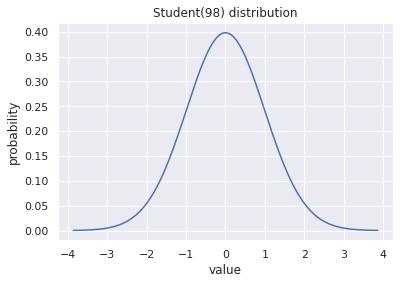

In [8]:
dist = sp.stats.t(len(X) - 2)
min_value = 1e-4
points = 300
support = np.linspace(dist.ppf(min_value), dist.isf(min_value), points)
sns.lineplot(support, dist.pdf(support))
plt.title(f"Student({len(X) - 2}) distribution")
plt.xlabel("value")
plt.ylabel("probability")
plt.show()

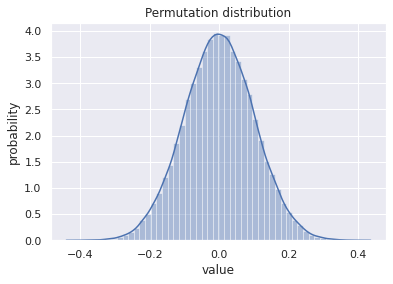

In [9]:
sns.distplot(permutation_test_significance(X, Y, verbose=False)[0])
plt.title("Permutation distribution")
plt.xlabel("value")
plt.ylabel("probability")
plt.show()

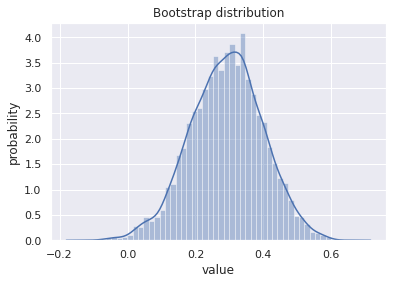

In [10]:
sns.distplot(bootstrap_test_significance(X, Y, verbose=False)[0])
plt.title("Bootstrap distribution")
plt.xlabel("value")
plt.ylabel("probability")
plt.show()

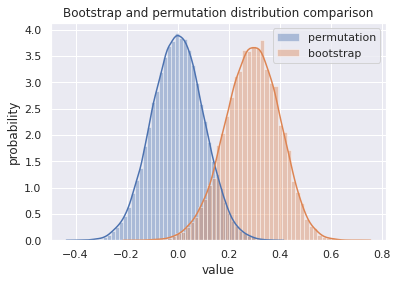

In [11]:
sns.distplot(permutation_test_significance(X, Y, verbose=False)[0], label='permutation')
sns.distplot(bootstrap_test_significance(X, Y, verbose=False)[0], label='bootstrap')
plt.title("Bootstrap and permutation distribution comparison")
plt.xlabel("value")
plt.ylabel("probability")
plt.legend()
plt.show()

**Выводы:** Бутстреп-критерий менее уверенно отвергает гипотезу о незначимости коэффициент корреляции и его распределение отличается смещенно относительно других критериев на величину равную коэффициенту корреляции, посчитанному по выборке. Также бутстреп-распределение более сплюснутое.

## Задача 2

Сравните две группы $S_1$ и $S_2$ размера $10 \times n$ по переменным $X_1, \dots, X_{10}$.

In [12]:
S1 = np.load("data2_1.npy")
S2 = np.load("data2_2.npy")

In [13]:
X_from_S1, X_from_S2 = S1[0], S2[0] # Test it

### U-тест Манна-Уиттни-Уилкоксона

U-Тест проверяет нулевую гипотезу о том, что с равной вероятностью случайно выбранное значение из одной совокупности будет меньше или больше случайно выбранного значения из второй совокупности. 

Статистика U-теста эквивалентна значению ROC-AUC: (https://en.wikipedia.org/wiki/Mann–Whitney_U_test).

В данной реализации вы можете не учитывать корректировку связанных рангов, а также использовать нормальное приближение и вычислять достигаемый уровень значимости через центральную предельную теорему. Для вычисления статистики можно пользоваться функцией `sp.stats.rankdata`. Тест должен быть _двусторонним_.

In [14]:
def mw_test(X, Y):
    S = np.concatenate((X, Y))
    ranks = sp.stats.rankdata(S, method='average')
    n = len(X)
    m = len(Y)
    t = ranks[:n].sum() - n * (n + 1) / 2
    mean = n * m / 2
    std = np.sqrt(n * m * (n + m + 1) / 12)
    p_val = 2 * sp.stats.norm(mean, std).sf(abs(t))
    return p_val

### Критерий однородности Колмогорова-Смирнова
Существует две версии критерия Колмогорова-Смирнова: одновыборочный (_согласия_) и двухвыборочный (_однородности_).

https://ru.wikipedia.org/wiki/Критерий_согласия_Колмогорова

Критерий _согласия_ Колмогорова предназначен для проверки гипотезы о принадлежности выборки некоторому закону распределения, то есть проверки того, что эмпирическое распределение соответствует предполагаемой модели.

Критерий _однородности_ Смирнова используется для проверки гипотезы о принадлежности двух независимых выборок одному закону распределения, то есть о том, что два эмпирических распределения соответствуют одному и тому же закону.

**Замечание**. Написать векторный вариант этой функции может быть непросто, и вы можете посмотреть исходные коды библиотеки `scipy` и попробовать написать свою интерпретацию метода.

* https://github.com/scipy/scipy/blob/v1.4.1/scipy/stats/mstats_basic.py#L1235-L1282
* https://github.com/scipy/scipy/blob/v0.14.0/scipy/stats/stats.py#L3809
* https://github.com/scipy/scipy/blob/v1.4.1/scipy/stats/stats.py#L6087-L6282

In [15]:
def ks_test(X, Y):
    S = np.concatenate((X, Y))
    indices = S.argsort()
    n = len(X)
    m = len(Y)
    difference = np.empty(n + m)
    difference[:n] = 1 / n
    difference[n:] = -1 / m
    difference = difference[indices]
    difference = np.cumsum(difference)
    t = np.abs(difference).max()
    D = np.sqrt(n * m / (n + m))
    prob = sp.stats.kstwobign.sf(t * D)
    return prob

In [16]:
res = defaultdict(list)

for i, (X_from_S1, X_from_S2) in enumerate(zip(S1, S2)):
    res["X"].append(i+1)
    res["Mann–Whitney"].append(mw_test(X_from_S1, X_from_S2))
    res["Kolmogorov–Smirnov"].append(ks_test(X_from_S1, X_from_S2))
    
pd.DataFrame(res)

,X,Mann–Whitney,Kolmogorov–Smirnov
0,1,6.900047e-03,7.991691e-03
1,2,1.153106e+00,9.981514e-01
2,3,3.952950e-01,5.806177e-01
3,4,2.520686e-01,2.106303e-21
4,5,7.018682e-01,2.416364e-19
5,6,8.149181e-01,1.245783e-19
6,7,1.999990e+00,4.452597e-04
7,8,2.238523e-07,6.727191e-06
8,9,1.998870e+00,1.008352e-02
9,10,1.568192e+00,1.008352e-02


Выясните, какие переменные являются значимыми на уровне $\alpha$ с учётом коррекции.

In [17]:
alpha = 0.05

### Бонферрони


Простая коррекция _заданных_ уровней значимости: $ \alpha_1 = ... = \alpha_m = \alpha/m $. Альтернативный вид — переход к модифицированным _достигаемым_ уровням значимости: $\tilde{p}_i = \min(1, mp_i)$.

**Подсказка**. В программной реализации брать минимум не обязательно.

In [18]:
def bonferroni_correction(p_vals, alpha=alpha):
    "Must return bool (!) array: reject/accept after correction"
    is_rejected = (p_vals * len(p_vals)) > alpha
    return is_rejected

### Бонферрони-Холма

_Нисходящий_ метод множественной проверки гипотез:

$$\alpha_1 = \dfrac{\alpha}{m}, \alpha_2 = \dfrac{\alpha}{m - 1}, \ldots, \alpha_i = \dfrac{\alpha}{m - i + 1}, \ldots, \alpha_m = \alpha.$$

Тогда из вариационного ряда, если $p_{i} \ge \alpha_i$, принять все нулевые гипотезы $H_{(i)}, H_{(i+1)} \ldots H_{(m)}$ и остановиться; иначе отвергнуть $H_{(i)}$ и продолжить. Каждый _достигаемый_ уровень значимости $p_{(i)}$ сравнивается со своим _заданным_ уровнем значимости $\alpha_i$. 

Иначе, модифицированные _достигаемые_ значимости (p-values): $\tilde{p}_{(i)} = \min \Big( 1, \max \big ( (m - i + 1)p_{(i)}, \tilde{p}_{(i - 1)}\big ) \Big )$ сравниваются с исходным _заданным_ уровнем значимости $\alpha$.

**Подсказка**. Воспользуйтесь функкцией `np.maximum.accumulate`. Перейти от вариационного ряда $\tilde{p}_{(i)}$ к исходному $\tilde{p}_i$ можно с помощью обратной перестановки сортированных индексов. Несложно построить обратную перестановку, используя тождество $f^{-1}f = e$ (https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy?rq=1)

In [19]:
def holm_correction(p_vals, alpha=alpha):
    "Must return bool (!) array: reject/accept after correction"
    indices = p_vals.argsort()
    n = len(p_vals)
    p_vals = np.maximum.accumulate(p_vals[indices] * (n - np.arange(n)))
    is_rejected = np.empty(p_vals.shape, dtype=np.bool)
    is_rejected[indices] = p_vals > alpha
    return is_rejected

### Бенджамини-Хохберга

_Восходящий_ метод множественной проверки гипотез:

$$\alpha_1 = \dfrac{\alpha}{m}, \alpha_2 = \dfrac{2\alpha}{m}, \ldots, \alpha_i = \dfrac{i\alpha}{m}, \ldots, \alpha_m = \alpha.$$

Тогда из вариационного ряда, если $p_{i} \le \alpha_i$, отвергнуть все нулевые гипотезы $H_{(1)}, H_{(2)} \ldots H_{(i)}$ и остановиться; иначе принять $H_{(i)}$ и продолжить. Каждый _достигаемый_ уровень значимости $p_{(i)}$ сравнивается со своим _заданным_ уровнем значимости $\alpha_i$. 

Иначе, модифицированные _достигаемые_ значимости (p-values): $\tilde{p}_{(i)} = \min \big( 1,  \dfrac{mp_{(i)}}{i}, \tilde{p}_{(i + 1)} \big )$ сравниваются с исходным _заданным_ уровнем значимости $\alpha$.

**Подсказка**. `np.minimum.accumulate` и `[::-1]`

In [20]:
def bendjamini_correction(p_vals, alpha=alpha):
    "Must return bool (!) array: reject/accept after correction"
    indices = p_vals.argsort()
    n = len(p_vals)
    p_vals = p_vals[indices] * n / np.arange(1, n + 1)
    p_vals = np.minimum.accumulate(p_vals[::-1])[::-1]
    is_rejected = np.empty(p_vals.shape, dtype=np.bool)
    is_rejected[indices] = p_vals > alpha
    return is_rejected

Сравните результаты и сделайте выводы. Проверьте корректность вычислений сравнив значения с библиотечной функцией `statsmodels.stats.multitest.multipletests`.

In [21]:
from statsmodels.stats.multitest import multipletests
res_accept_reject = {}
df = pd.DataFrame(res)
for method in ('my', 'library'):
    for column in df.columns[1:]:
        name_funcs = [
            ('bonferroni', bonferroni_correction),
            ('homl', holm_correction),
            ('bendjamini', bendjamini_correction)
        ] if method == 'my' else [
            ('bonferroni', lambda *args, **kwargs: ~multipletests(*args, **kwargs, method='bonferroni')[0]),
            ('homl', lambda *args, **kwargs: ~multipletests(*args, **kwargs, method='holm')[0]),
            ('bendjamini', lambda *args, **kwargs: ~multipletests(*args, **kwargs, method='fdr_bh')[0])
        ]
        for name, func in name_funcs:
            res_accept_reject[(method, column, name)] = func(df[column].values, alpha=alpha)

result = pd.DataFrame(res_accept_reject)
result

my                                                         \
  Mann–Whitney                   Kolmogorov–Smirnov                     
    bonferroni   homl bendjamini         bonferroni   homl bendjamini   
0         True   True      False               True  False      False   
1         True   True       True               True   True       True   
2         True   True       True               True   True       True   
3         True   True       True              False  False      False   
4         True   True       True              False  False      False   
5         True   True       True              False  False      False   
6         True   True       True              False  False      False   
7        False  False      False              False  False      False   
8         True   True       True               True  False      False   
9         True   True       True               True  False      False   

       library                                                         
  Mann–Whitney                   Kolmogorov–Smirnov                    
    bonferroni   homl bendjamini         bonferroni   homl bendjamini  
0         True   True      False               True  False      False  
1         True   True       True               True   True       True  
2         True   True       True               True   True       True  
3         True   True       True              False  False      False  
4         True   True       True              False  False      False  
5         True   True       True              False  False      False  
6         True   True       True              False  False      False  
7        False  False      False              False  False      False  
8         True   True       True               True  False      False  
9         True   True       True               True  False      False

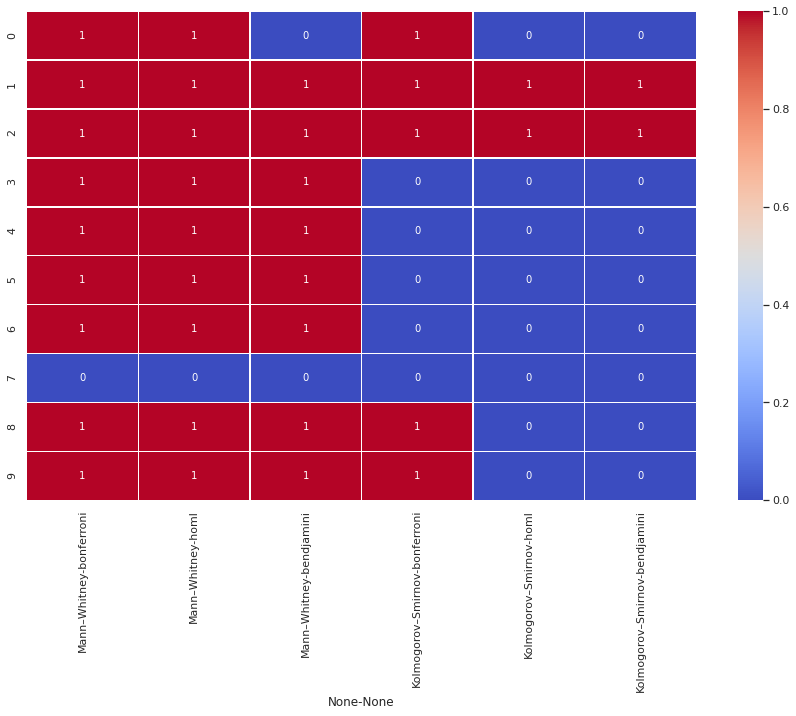

In [22]:
plt.figure(figsize=(15, 9))
sns.heatmap(result['my'], annot=True, linewidths=.5, cmap="coolwarm")
plt.show()

> Синяя ячейка означает, что гипотезу можно отвергнуть, красная - гипотеза не может быть отвергнута.

Рассмотрим дополнительно $\alpha=0.01$:

In [23]:
from statsmodels.stats.multitest import multipletests
res_accept_reject = {}
df = pd.DataFrame(res)
for method in ('my', 'library'):
    for column in df.columns[1:]:
        name_funcs = [
            ('bonferroni', bonferroni_correction),
            ('homl', holm_correction),
            ('bendjamini', bendjamini_correction)
        ] if method == 'my' else [
            ('bonferroni', lambda *args, **kwargs: ~multipletests(*args, **kwargs, method='bonferroni')[0]),
            ('homl', lambda *args, **kwargs: ~multipletests(*args, **kwargs, method='holm')[0]),
            ('bendjamini', lambda *args, **kwargs: ~multipletests(*args, **kwargs, method='fdr_bh')[0])
        ]
        for name, func in name_funcs:
            res_accept_reject[(method, column, name)] = func(df[column].values, alpha=0.01)

result = pd.DataFrame(res_accept_reject)
result

my                                                         \
  Mann–Whitney                   Kolmogorov–Smirnov                     
    bonferroni   homl bendjamini         bonferroni   homl bendjamini   
0         True   True       True               True   True       True   
1         True   True       True               True   True       True   
2         True   True       True               True   True       True   
3         True   True       True              False  False      False   
4         True   True       True              False  False      False   
5         True   True       True              False  False      False   
6         True   True       True              False  False      False   
7        False  False      False              False  False      False   
8         True   True       True               True   True       True   
9         True   True       True               True   True       True   

       library                                                         
  Mann–Whitney                   Kolmogorov–Smirnov                    
    bonferroni   homl bendjamini         bonferroni   homl bendjamini  
0         True   True       True               True   True       True  
1         True   True       True               True   True       True  
2         True   True       True               True   True       True  
3         True   True       True              False  False      False  
4         True   True       True              False  False      False  
5         True   True       True              False  False      False  
6         True   True       True              False  False      False  
7        False  False      False              False  False      False  
8         True   True       True               True   True       True  
9         True   True       True               True   True       True

*Дополнительная информация:* на самом деле лишь переменные $X_1$, $X_2$ и $X_3$ имеют одинаковое распределение.

Не забудьте сделать выводы!

**Выводы:** Из графиков в "Задаче 1" видно, что $p$-значения распределены по закону близкому к нормальному, поэтому будем опираться на критерий Колмогорова-Смирнова. Известно, что метод Бонферрони является слишком грубым, поэтому расмотрим два других метода. Они дают идентичные результаты и говорят о том, что мы не можем отвергнуть гипотезу об одинаковости распределения только для переменных $X_2$, $X_3$. При этом мы понимаем, что мы можем ошибиться с уровнем значимости $\alpha=0.05$, хотя бы в отвержении одной гипотезы, что мы и делаем, т.к. на самом деле ешё $X_1$ имеет одинаковое распределение переменных и следовательно данная гипотеза не должна была быть отвергнута. Заметим, что при уровне значимости $\alpha=0.01$ мы не отвергаем данную гипотезу, и действуем более консервативно, хотя при этом дополнительно не можем отвергнуть гипотезу об одинаковости распределений переменных $X_8$, $X_9$. Данные результаты лишний раз подтверждают, что идеальных методов оценивания гипотез (в данном случае множественных) нет.